# Лаборная работа 4

### Задание

Объект движется на плоскости $\mathbb{R}^2$ согласно следующему закону:
$$
\mathbf{x}_{n+1}=\mathbf{A} \mathbf{x}_n+\mathbf{B} \mathbf{u}_n+\mathbf{C} \mathbf{w}_{n+1}
$$

где
- $\mathbf{x}_n=\left(x_n^1, \dot{x}_n^1, \ddot{x}_n^1, x_n^2, \dot{x}_n^2, \ddot{x}_n^2\right)$ - вектор состояния отслеживаемого объекта: $\left(x_n^1, x_n^2\right)$ - координаты объекта; $\left(\dot{x}_n^1, \dot{x}_n^2\right)$ - вектор скорости; $\left(\ddot{x}_n^1, \ddot{x}_n^2\right)$ - вектор ускорения.
- $\left\{\mathbf{u}_n\right\}$ - управляющие команды, которые моделируются марковской цепью с множеством состояний
$$
\left\{(0,0)^T,(3.5,0)^T,(0,3.5)^T,(-3.5,0)^T,(0,-3.5)^T\right\}
$$

и матрицей переходных вероятностей
$$
\mathbf{P}=\frac{1}{20}\left(\begin{array}{ccccc}
16 & 1 & 1 & 1 & 1 \\
1 & 16 & 1 & 1 & 1 \\
1 & 1 & 16 & 1 & 1 \\
1 & 1 & 1 & 16 & 1 \\
1 & 1 & 1 & 1 & 16
\end{array}\right)
$$
- $\left\{\mathbf{w}_n\right\}$ - последовательность независимых с. в., имеющих распределение $\mathcal{N}\left(\mathbf{0}_{2 \times 1}, \sigma^2 \mathbf{I}\right)$, $\sigma=0.5$.
$$
\mathbf{A}=\left(\begin{array}{cc}
\tilde{\mathbf{A}} & \mathbf{0}_{3 \times 3} \\
\mathbf{0}_{3 \times 3} & \tilde{\mathbf{A}}
\end{array}\right), \quad \mathbf{B}=\left(\begin{array}{cc}
\tilde{\mathbf{B}} & \mathbf{0}_{3 \times 1} \\
\mathbf{0}_{3 \times 1} & \tilde{\mathbf{B}}
\end{array}\right), \quad \mathbf{C}=\left(\begin{array}{cc}
\tilde{\mathbf{C}} & \mathbf{0}_{3 \times 1} \\
\mathbf{0}_{3 \times 1} & \tilde{\mathbf{C}}
\end{array}\right)
$$

где
$$
\tilde{\mathbf{A}}=\left(\begin{array}{ccc}
1 & \Delta l & \Delta l^2 / 2 \\
0 & 1 & \Delta l \\
0 & 0 & \alpha
\end{array}\right), \quad \tilde{\mathbf{B}}=\left(\begin{array}{c}
\Delta l^2 / 2 \\
\Delta l \\
0
\end{array}\right), \quad \tilde{\mathbf{C}}=\left(\begin{array}{c}
\Delta l^2 / 2 \\
\Delta t \\
1
\end{array}\right)
$$
$\Delta t=0.5$ - период дискретизации; параметр $\alpha=0.6$.
Начальный вектор $\mathbf{x}_0$ имеет распределение $\mathcal{N}\left(\mathbf{0}_{6 \times 1}, \operatorname{diag}(500,5,5,200,5,5)\right) ; \mathbf{u}_0$ имеет равномерное распределение на множестве (2).

Предполагается, что объект движется в зоне покрытия $L$ базовых станций с известными координатами $\mathbf{z}^{(\ell)}=\left(z_1^{(\ell)}, z_2^{(\ell)}\right), \quad \ell=1, \ldots, L$. Координаты $L=6$ базовых станций записаны в файле stations.txt. На мобильном объекте установлено принимающее устройство, которое регистрирует сигналы от базовых станций. Положение мобильного объекта определяется на основе показателя уровня принимаемого сигнала (RSSI - Received Signal Strength Indicator). Предполагается следующая модель наблюдения, согласно которой регистрируемая мощность сигнала (в децибелах) определяется соотношением:
$$
y_n^{\ell}=P_0-10 \beta \lg d_{\ell, n}+v_n^{\ell}, \quad \ell=1, \ldots, L
$$

где $P_0=90(д Б)-$ мощность сигнала, передаваемого базовой станцией; $\beta=3-$ коэффициент, характеризующий среду распространения сигнала; $d_{\ell, n}$ - расстояние от базовой станции $\ell$ до мобильного объекта в момент времени $n ;\left\{v_n^{\ell}\right\}_{\ell=1}^L$ - независимые нормально распределенные случайные величины с нулевым средним и стандартным отклонением $\delta=1.5$ (дБ).

В файле RSSI-measurements.txt записаны измерения RSSI от всех базовых станций: $\mathbf{y}_{0: m}^{\ell}=\left(y_0^{\ell}, \ldots, y_m^{\ell}\right), \ell=1, \ldots, L$. Требуется с помощью фильтра частиц восстановить траекторию мобильного объекта.


In [32]:
import random as rnd
import numpy as np
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
import copy
from scipy.spatial.distance import euclidean

In [33]:
alpha = 0.6

# Период дискретизации
delta_t = 0.5

# Отклонение с.в. w_n
sigma = 0.5

# Стандартное отклонение
delta = 1.5

# Коеффициент, характеризующий среду распространения сигнала
beta = 3

# Число станций
L = 6

# Мощность сигнала, передаваемого базовой станцией
P0 = 90

# Число частиц
M = 100

In [34]:
A_part = np.array([
    [1, delta_t, delta_t**2/2],
    [0, 1, delta_t],
    [0, 0, alpha]
])
B_part = np.array([delta_t**2/2, delta_t, 0])
C_part = np.array([delta_t**2/2, delta_t, 1])

# Матрица системы, связывающая скрытое наблюдение с состоянием
A = np.block([[A_part, np.zeros((3, 3))], [np.zeros((3, 3)), A_part]])

# Матрица управления, связывающая управляющие команды с состоянием
B = np.block([[B_part, np.zeros(3)], [np.zeros(3), B_part]]).T

# Матрица выхода, связывающая шум с состоянием
C = np.block([[C_part, np.zeros(3)], [np.zeros(3), C_part]]).T

print("А = \n", A)
print("В = \n", B)
print("С = \n", C)

А = 
 [[1.    0.5   0.125 0.    0.    0.   ]
 [0.    1.    0.5   0.    0.    0.   ]
 [0.    0.    0.6   0.    0.    0.   ]
 [0.    0.    0.    1.    0.5   0.125]
 [0.    0.    0.    0.    1.    0.5  ]
 [0.    0.    0.    0.    0.    0.6  ]]
В = 
 [[0.125 0.   ]
 [0.5   0.   ]
 [0.    0.   ]
 [0.    0.125]
 [0.    0.5  ]
 [0.    0.   ]]
С = 
 [[0.125 0.   ]
 [0.5   0.   ]
 [1.    0.   ]
 [0.    0.125]
 [0.    0.5  ]
 [0.    1.   ]]


In [35]:
# Управляющие команды
U = np.array([
    np.array([0, 0]).T,
    np.array([3.5, 0]).T,
    np.array([0, 3.5]).T,
    np.array([-3.5, 0]).T,
    np.array([0, -3.5]).T])
u_count = len(U)
print(u_count, "\n", "U = \n", U)

5 
 U = 
 [[ 0.   0. ]
 [ 3.5  0. ]
 [ 0.   3.5]
 [-3.5  0. ]
 [ 0.  -3.5]]


In [36]:
# Матрица переходных вероятностей
P = 1 / 20 * np.array([[16, 1, 1, 1, 1],
                       [1, 16, 1, 1, 1],
                       [1, 1, 16, 1, 1],
                       [1, 1, 1, 16, 1],
                       [1, 1, 1, 1, 16]])
print("P = \n", P)

P = 
 [[0.8  0.05 0.05 0.05 0.05]
 [0.05 0.8  0.05 0.05 0.05]
 [0.05 0.05 0.8  0.05 0.05]
 [0.05 0.05 0.05 0.8  0.05]
 [0.05 0.05 0.05 0.05 0.8 ]]


In [37]:
# Считываем координаты станций из файла
stations = []
with open('./lab_files/stations.txt', 'r') as f:
    x = f.readline().split()
    y = f.readline().split()
    stations = np.vstack((x, y)).T
stations = np.array(stations).reshape((6, -1)).astype(float)
print(stations)
# Считываем показания станций
y = []
with open('./lab_files/RSSI-measurements.txt', 'r') as f:
    for l in f.readlines():
        y.extend(l.split())
y = np.array(y).reshape((len(stations), -1)).astype(float).T
print(y)

[[    0.      4000.    ]
 [    0.     -4000.    ]
 [ 3464.1016  2000.    ]
 [ 3464.1016 -2000.    ]
 [-3464.1016 -2000.    ]
 [-3464.1016  2000.    ]]
[[-18.67918   -18.248671  -17.303319  -17.173036  -18.115797  -17.553736 ]
 [-16.269286  -18.623889  -16.816012  -18.594344  -18.118293  -17.972993 ]
 [-18.83336   -16.180802  -19.280249  -19.279911  -18.00498   -17.405444 ]
 ...
 [ -5.4839427 -27.471672  -12.888184  -21.71415   -27.468836  -22.955865 ]
 [ -7.9050906 -26.371108  -11.930547  -20.16127   -23.442843  -17.902805 ]
 [ -4.209267  -25.189529  -11.057371  -22.052968  -21.621816  -19.883949 ]]


In [38]:
# ИНИЦИАЛИЗАЦИЯ ЧАСТИЦ
# Начальный вектор х_0
# (x1, v1, a1, x2, v2, a2)
# где (x1, x2) - координаты объекта, (v1, v2) - вектор скорости, (а1, а2) - вектор ускорения
x_s = np.random.multivariate_normal(np.zeros((L)), np.diag((500, 5, 5, 200, 5, 5)), M)

# Выбор начального состояния u_0
u_s = np.random.randint(0, 5, M)

# Начальный вес каждой частицы = 1/M
weights = np.ones(M) / M

# Траектория
path = []

# Цикл по наблюдениям у - показаниям сигналов со станций
for y_n in y:
    # ПРОГНОЗ
    for i in range(M):

        # Управление для текущей частицы
        # Какое-то значение из матрицы управления
        u_i = U[u_s[i]]

        # Шум для текущей частицы, вектор {w_x, w_y}
        w_i = np.random.normal(0, sigma, 2)

        # Обновление частицы в соответствии с уравнением движения
        x_s[i] = A @ x_s[i] + B @ u_i + C @ w_i

        # Обновление управления по марковской цепи с учетом матрицы переходных вероятностей
        # P[u_s[i]] - строка матрицы перехода для текущего состояния
        u_s[i] = np.random.choice(5, p = P[u_s[i]])

    # КОРРЕКЦИЯ (Взвешивание)
    for i in range(M):

      # Уровни сигнала от всех станций на текущем шаге
      y_t = np.zeros(L)

      for st in range(len(y_t)):
        # Расстояние до станций - евклидово расстояние
        d = euclidean(np.array(x_s)[i, [0, 3]], stations[st])
        # Проверка на ненулевое расстояние
        d = max(d, 1e-10)

        # Ожидаемый уровень сигнала, заполняем матрицу
        y_t[st] = P0 - 10 * beta * np.log10(d)

      # Вес частицы - вероятность получить текущие измерения по всем станциям при ее текущем состоянии
      # 1 \ (delta * sqrt(2pi)) * exp{- (y_n - y_t)^2 \ 2 * delta^2} - нормальное распределение с параметрами (y_n, y_t)
      # y_n - наблюдаемые, y_t - предсказанные
      weights[i] = np.prod(stats.norm.pdf(y_n, loc=y_t, scale=delta))

    # Нормализация весов
    weights /= np.sum(weights)

    # РЕСЭМПЛИНГ
    # indices = np.random.choice(M, size=M, p=weights)
    # x_s = x_s[indices]
    # u_s = u_s[indices]

    u_tilde = np.random.uniform(0, 1)
    u = (np.arange(M) + u_tilde) / M

    cumulative_weights = np.cumsum(weights)
    # Пример попадания в интервал
    # u = 0.025, 0.225, 0.425, 0.625, 0.825
    # cumul_weights = 0.02, 0.1, 0.5, 1.0
    # 1, 2, 2, 3, 3
    resampled_indices = np.searchsorted(cumulative_weights, u)
    x_s = x_s[resampled_indices]
    u_s = u_s[resampled_indices]

    # Среднее арифметическое по всем частицам
    x_mean = np.mean(x_s, axis=0)
    path.append(x_mean)

    weights = np.ones(M) / M

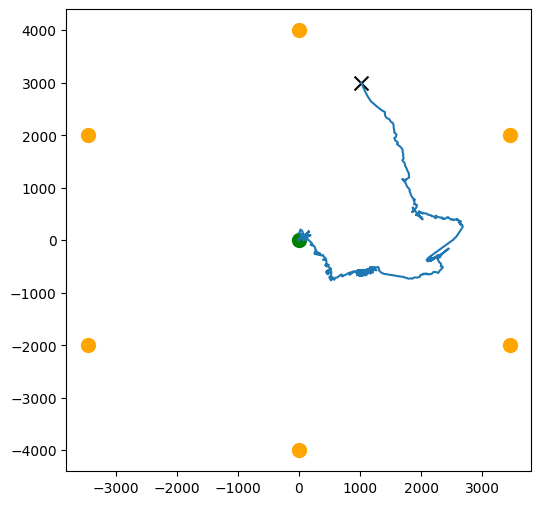

In [39]:
plt.figure(figsize=(6, 6))
plt.scatter(stations[:, 0], stations[:, 1],
            c='orange', s=100, marker='o',
            label='Базовые станции')
path = np.array(path)
plt.plot(path[:, 0], path[:, 3])
plt.scatter(path[0, 0], path[0, 3],
            c='green', s=100,
            marker='o', label='Начало')
plt.scatter(path[-1, 0], path[-1, 3],
            c='black', s=100,
            marker='x', label='Конец')
plt.show()